In [22]:
import numpy as np
import time

In [26]:
def analytic_probability(a:float, x0: float, M: float, mu: float) -> float:
    return np.exp(mu * (M - x0)) * (np.sinh((x0-a)*np.abs(mu)) / np.sinh((M-a)*np.abs(mu)))
                                    
true_prob = analytic_probability(0, 1, 8, -1)
print(true_prob)


7.18993625296382e-07


In [21]:
def simulate_trajectory(start_pos, mu, dt=0.01):
    """
    Simulate a Brownian motion with drift from start_pos until absorption at 0.
    Returns the maximum value attained during the trajectory.
    """
    x = start_pos
    max_x = x
    while x > 0:
        # Update position using Euler-Maruyama method
        x += mu * dt + np.sqrt(dt) * np.random.randn()
        max_x = max(max_x, x)
    return max_x

def ams_algorithm(n, k, x0, M, mu):
    """
    Adaptive Multilevel Splitting algorithm for rare event estimation.
    
    Parameters:
    n (int): Number of particles
    k (int): Number of particles to retain in each iteration
    x0 (float): Initial position of the process
    M (float): Rare event threshold
    mu (float): Drift coefficient (negative)
    
    Returns:
    float: Estimated probability of reaching M before 0
    """
    p = k / n  # Retention fraction
    particles = np.zeros(n)
    
    # Initialize particles by simulating from x0
    for i in range(n):
        particles[i] = simulate_trajectory(x0, mu)
    
    N = 0  # Number of iterations
    while True:
        # Check for particles that reached M
        r = np.mean(particles >= M)
        if r > 0:
            # Estimate the probability and exit
            return r * (p ** N), N, r
        
        # Sort particles in descending order of maxima
        sorted_indices = np.argsort(-particles)
        sorted_particles = particles[sorted_indices]
        q = sorted_particles[k-1]  # Threshold for this iteration
        
        # Identify survivors (indices of particles >= q)
        survivors = sorted_indices[:k]
        non_survivors = sorted_indices[k:]
        
        # Resample non-survivors by cloning survivors
        for i in non_survivors:
            # Choose a random survivor
            parent = np.random.choice(survivors)
            # Simulate new trajectory starting from threshold q
            particles[i] = simulate_trajectory(q, mu)
        
        N += 1

# Compute variance
def compute_variance(alpha_hat, N_hat, r_hat, p):
    term1 = N_hat * (1 - p) / p
    term2 = (1 - r_hat) / r_hat
    variance = (alpha_hat ** 2) * (term1 + term2)
    return variance

if __name__ == "__main__":
    # Parameters
    x0 = 1.0    # Initial position
    M = 10    # Rare event threshold
    mu = -1.0   # Drift coefficient
    n = 20000   # Number of particles
    k = int(0.9 * n)  # Number of particles to retain
    
    # Start overall timer
    list_prob = []

    # Start timer for this trial
    trial_start = time.time()

    estimated_prob, N_hat, r_hat = ams_algorithm(n, k, x0, M, mu)
    p = k/n
    
    variance = compute_variance(estimated_prob, N_hat, r_hat, p)
    
    list_prob.append(estimated_prob)

    # End timer for this trial
    trial_end = time.time()
    print(f"Trial took {trial_end - trial_start:.4f} seconds")
    print(f"Estimated Prob: {estimated_prob}")
    print(f"Variance: {variance}")
    print(f"Stdev: {np.sqrt(variance)}")

Trial took 73.3315 seconds
Estimated Prob: 9.831352523777666e-09
Variance: 1.933883092875364e-12
Stdev: 1.390641252399541e-06


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_trajectory_with_path(start_pos, mu, M, dt=0.01):
    """Simulates trajectory and returns both max and path"""
    x = start_pos
    trajectory = [x]
    max_x = x
    while x > 0:
        dx = mu * dt + np.sqrt(dt) * np.random.randn()
        x += dx
        trajectory.append(x)
        max_x = max(max_x, x)
        if max_x >= M:
            break  # Early exit if M is reached
    return max_x, trajectory

def ams_algorithm_with_trajectory(n, k, x0, M, mu):
    """AMS algorithm that returns successful trajectory"""
    p = k / n
    particles = [{'max': None, 'trajectory': None} for _ in range(n)]
    successful_trajectory = None

    # Initialize particles
    for i in range(n):
        max_x, trajectory = simulate_trajectory_with_path(x0, mu, M)
        particles[i]['max'] = max_x
        particles[i]['trajectory'] = trajectory
        if max_x >= M:
            return trajectory  # Return immediately if found

    N = 0
    while True:
        max_values = np.array([p['max'] for p in particles])
        r = np.mean(max_values >= M)
        if r > 0:
            for p in particles:
                if p['max'] >= M:
                    return p['trajectory']

        # Sort and find threshold
        sorted_indices = np.argsort(-max_values)
        q = max_values[sorted_indices[k-1]]

        # Resample non-survivors
        for i in sorted_indices[k:]:
            parent_idx = np.random.choice(sorted_indices[:k])
            parent_traj = particles[parent_idx]['trajectory']
            
            # Find split point where trajectory first reaches q
            split_idx = next((i for i, x in enumerate(parent_traj) if x >= q), len(parent_traj)-1)
            start_pos = parent_traj[split_idx]
            
            # Simulate new trajectory from split point
            new_max, new_traj = simulate_trajectory_with_path(start_pos, mu, M)
            
            # Combine trajectories
            combined_traj = parent_traj[:split_idx+1] + new_traj[1:]
            particles[i]['max'] = max(new_max, q)
            particles[i]['trajectory'] = combined_traj
            
            if new_max >= M:
                return combined_traj

        N += 1

# Parameters
x0 = 1.0
M = 4
mu = -1.0
n = 20000
k = int(0.9 * n)

# Get trajectory and plot
trajectory = ams_algorithm_with_trajectory(n, k, x0, M, mu)
time_points = np.arange(len(trajectory)) * 0.01

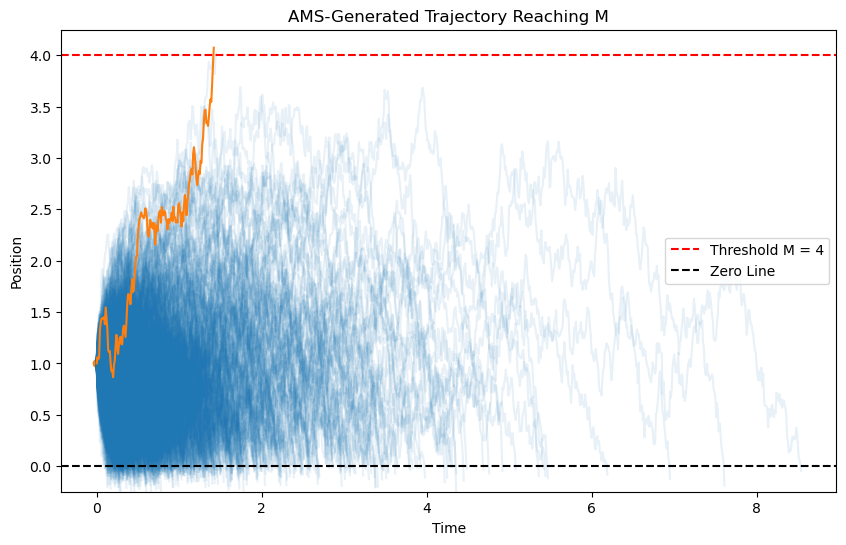

In [16]:
plt.figure(figsize=(10, 6))

for i in range(1000):
    max_x, norm_traj = simulate_trajectory_with_path(x0, mu, M)
    norm_time = [i*0.01 for i in range(len(norm_traj))]

    plt.plot(norm_time, norm_traj, color = 'tab:blue', alpha = 0.1)

plt.scatter([0], [1], color ='tab:orange')
plt.plot(time_points, trajectory, color = 'tab:orange')

plt.axhline(M, color='r', linestyle='--', label=f'Threshold M = {M}')
plt.axhline(0, color='k', linestyle='--', label=f'Zero Line')
plt.xlabel('Time')
plt.ylabel('Position')
plt.ylim([-0.25, M + 0.25])
plt.title('AMS-Generated Trajectory Reaching M')
plt.legend(loc = 'right')
plt.show()

In [42]:


def simulate_trajectory(start_pos, mu, dt=0.01):
    """
    Simulate a Brownian motion with drift from start_pos until absorption at 0.
    Returns the maximum value attained during the trajectory.
    """
    x = start_pos
    max_x = x
    while x > 0:
        # Update position using Euler-Maruyama method
        x += mu * dt + np.sqrt(dt) * np.random.randn()
        max_x = max(max_x, x)
    return max_x

def ams_algorithm(n, k, x0, M, mu):
    """
    Adaptive Multilevel Splitting algorithm for rare event estimation.
    
    Parameters:
    n (int): Number of particles
    k (int): Number of particles to retain in each iteration
    x0 (float): Initial position of the process
    M (float): Rare event threshold
    mu (float): Drift coefficient (negative)
    
    Returns:
    float: Estimated probability of reaching M before 0
    """
    p = k / n  # Retention fraction
    particles = np.zeros(n)
    
    # Initialize particles by simulating from x0
    for i in range(n):
        particles[i] = simulate_trajectory(x0, mu)
    
    N = 0  # Number of iterations
    while True:
        # Check for particles that reached M
        r = np.mean(particles >= M)
        if r > 0:
            # Estimate the probability and exit
            return r * (p ** N), N, r
        
        # Sort particles in descending order of maxima
        sorted_indices = np.argsort(-particles)
        sorted_particles = particles[sorted_indices]
        q = sorted_particles[k-1]  # Threshold for this iteration
        
        # Identify survivors (indices of particles >= q)
        survivors = sorted_indices[:k]
        non_survivors = sorted_indices[k:]
        
        # Resample non-survivors by cloning survivors
        for i in non_survivors:
            # Choose a random survivor
            parent = np.random.choice(survivors)
            # Simulate new trajectory starting from threshold q
            particles[i] = simulate_trajectory(q, mu)
        
        N += 1

# Example usage
import time

if __name__ == "__main__":
    # Parameters
    x0 = 1.0    # Initial position
    M = 8.0    # Rare event threshold
    mu = -1.0   # Drift coefficient
    n = 20000   # Number of particles
    k = int(0.9 * n)  # Number of particles to retain
    
    # Start overall timer
    list_prob = []
    overall_start = time.time()

    for i in range(20):    
        # Start timer for this trial
        trial_start = time.time()

        estimated_prob, N_hat, r_hat = ams_algorithm(n, k, x0, M, mu)
        list_prob.append(estimated_prob)

        # End timer for this trial
        trial_end = time.time()
        print(f"Trial {i} took {trial_end - trial_start:.4f} seconds")

    # End overall timer
    overall_end = time.time()
    print(f"Total execution time: {overall_end - overall_start:.4f} seconds")

Trial 0 took 26.2370 seconds
Trial 1 took 25.4843 seconds
Trial 2 took 13.0663 seconds
Trial 3 took 15.9255 seconds
Trial 4 took 28.1324 seconds
Trial 5 took 29.0770 seconds
Trial 6 took 19.8659 seconds
Trial 7 took 23.0941 seconds
Trial 8 took 31.8390 seconds
Trial 9 took 33.4469 seconds
Trial 10 took 8.2927 seconds
Trial 11 took 23.7828 seconds
Trial 12 took 26.8743 seconds
Trial 13 took 36.3392 seconds
Trial 14 took 27.1332 seconds
Trial 15 took 21.4797 seconds
Trial 16 took 23.5990 seconds
Trial 17 took 34.9416 seconds
Trial 18 took 27.3447 seconds
Trial 19 took 26.0253 seconds
Total execution time: 501.9829 seconds


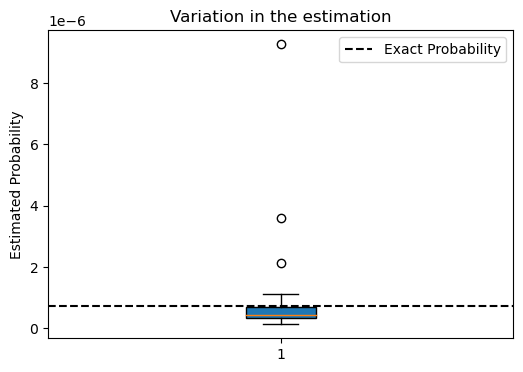

In [43]:
import matplotlib.pyplot as plt

# Create a boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(list_prob, vert=True, patch_artist=True)
plt.axhline(true_prob, color='k', linestyle='--', label=f'Exact Probability')
plt.title("Variation in the estimation")
plt.ylabel("Estimated Probability")
# plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.legend()
# Show the plot
plt.show()

In [21]:


rel_list_prob = []

for f in list_prob:
    rel_list_prob.append((abs(f - P_exact)/P_exact)*100)
    print(f"Relative error: {(abs(f - P_exact)/P_exact)*100:.2f} %")

Relative error: 33.06 %
Relative error: 94.66 %
Relative error: 60.47 %
Relative error: 88.84 %
Relative error: 76.66 %
Relative error: 8.17 %
Relative error: 76.66 %
Relative error: 81.09 %
Relative error: 64.42 %
Relative error: 82.98 %
Relative error: 395.56 %
Relative error: 137.02 %
Relative error: 87.60 %
Relative error: 88.84 %
Relative error: 87.60 %
Relative error: 163.36 %
Relative error: 79.90 %
Relative error: 60.47 %
Relative error: 51.20 %
Relative error: 55.51 %


In [22]:
rel_list_prob = np.array(rel_list_prob)

In [23]:
np.mean(rel_list_prob), np.std(rel_list_prob)

(np.float64(93.70347572610875), np.float64(76.26856324463745))

In [5]:
mu = -1
b = 12
a = 0
x0 = 1

P_exact = np.exp(mu*(b - x0))*(np.sinh((x0 - a)*np.abs(mu))/np.sinh((b - a)*np.abs(mu)))

print(f"Relative error: {(abs(estimated_prob - P_exact)/P_exact)*100:.2f} %")

NameError: name 'np' is not defined

In [1]:
import matplotlib.pyplot as plt

In [8]:
def simulate_trajectory_full(start_pos, mu, dt=0.01):
    """
    Simulate a Brownian motion with drift from start_pos until absorption at 0.
    Returns the maximum value attained during the trajectory.
    """
    x = start_pos
    max_x = x
    
    x_list = []
    
    while x > 0:
        # Update position using Euler-Maruyama method
        x_list.append(x)
        x += mu * dt + np.sqrt(dt) * np.random.randn()
        max_x = max(max_x, x)
    return max_x, x_list



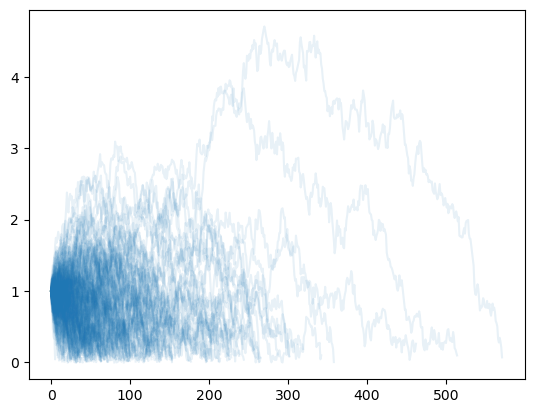

In [13]:
for i in range(200):
    max_x, x_list = simulate_trajectory_full(x0, mu)
    plt.plot(x_list, color = 'tab:blue', alpha = 0.1)